# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [11]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "pad64"
    IMAGE_MIN_DIM = 4096
    IMAGE_MAX_DIM = 4096
    DETECTION_MIN_CONFIDENCE = 0.2
    RPN_NMS_THRESHOLD = 0.2 # New

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.2
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  4096
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  4096
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [4096 4096    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [12]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [13]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


## Run Object Detection

Processing 1 images
image                    shape: (2992, 5152, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 4096, 7104, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 7104.00000  float64
anchors                  shape: (1, 7267392, 4)       min:   -0.08841  max:    1.07278  float32


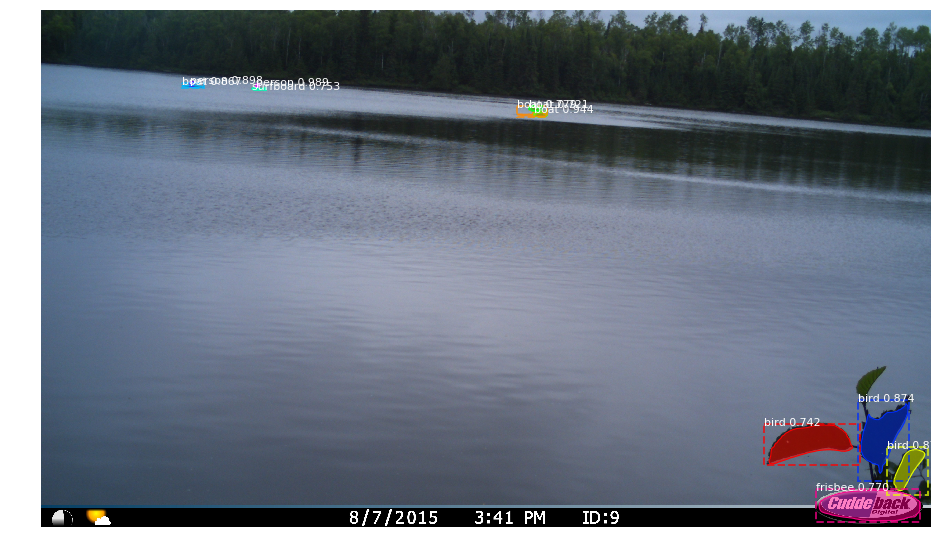

In [15]:
# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
image = skimage.io.imread('/Users/aaron/Desktop/matt_images/featuredetection/L__00010.JPG')

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

## Count features and add to pandas dataframe

In [ ]:
import pandas as pd
import glob, time

jpgs = sorted(glob.glob(os.path.join('/Users/aaron/Desktop/LeoEast', '*.JPG')))

counter = 1
data = []
for jpg in jpgs:
    start = time.time()
    image = skimage.io.imread(jpg)
    
    # Run detection
    results = model.detect([image], verbose=0) # switch to verbose = 1 for image info
    
    # Count features
    vals = [item for item in list(results[0].get('class_ids')) if str(item) in ['1','9']]
    print('There are {0} watercraft and {1} boat anglers'.format(vals.count(9), vals.count(1)))

    # Visualize results
    #r = results[0]
    #visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
    #                            class_names, r['scores'])
    
    # Add results to pandas dataframe
    data.append({'image_path':os.path.basename(jpg), 'watercraft':vals.count(9), 'boat_anglers':vals.count(1)})
    
    # Keep a verbose tally on where we are at on the processing
    end = time.time()
    print('{0}: {1} of {2} processed in {3} seconds'.format(os.path.basename(jpg), counter, len(jpgs), round(end - start, 2)))
    counter += 1
    
df = pd.DataFrame(data, columns = ['image_path', 'watercraft', 'boat_anglers'])
df
print("Processing complete")


## Assess the boat count accuracy




In [ ]:
from sklearn.metrics import mean_squared_error
import scipy

# Write df to csv for safe keeping
#df.to_csv('/Users/aaron/gdrive/projects/fisheries_census_project/data/outdata/1st_run.csv')

# Read Matt's csv 
df2 = pd.read_csv('/Users/aaron/gdrive/projects/fisheries_census_project/data/indata/LeoEast.csv')

# Concatenate dfs
result = pd.concat([df, df2], axis =1)

# Assess accuracy
result['diff'] = result['Watercraft'] - result['watercraft']

# Overall accuracy
overall_accuracy = round(len(result[(result['diff'] == 0)]) / len(result), 2)

# Accuracy for only those images where an object was detected in the real dataset
# Select only rows where true > 0
subset = result[result.Watercraft > 0]
subset_accuracy = round(len(subset[(subset['diff'] == 0)]) / len(subset), 2)

# Accuracy of boat vs non-boat
binary_accuracy = ''

# Calculate MSE for all samples
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
mse = mean_squared_error(result.Watercraft, result.watercraft)

# Calculate MSE for subset

# Confusion matrix
cm = confusion_matrix(result.Watercraft, result.watercraft)

# Wilcoxon Signed Rank Test using Pratt zero method
# https://stats.stackexchange.com/questions/347930/how-to-consider-pratt-zero-method-in-wilcoxon-test-of-r-which-is-available-in
p = scipy.stats.wilcoxon(result.Watercraft, result.watercraft, zero_method = 'pratt')

# Confusion matrix

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = np.array(['0', '1', '2', '3', '4'])
plot_confusion_matrix(result['Watercraft'], result['watercraft'], classes = class_names,
                      title='Confusion matrix, without normalization')

# Calculate Kappa
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(result['Watercraft'], result['watercraft']))

from sklearn.metrics import accuracy_score
print(accuracy_score(result['Watercraft'], result['watercraft']))


In [ ]:
print(mse)
print(subset_accuracy) # Note that this is exact--not one or more off
print(overall_accuracy)

In [ ]:
cm

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [ ]:
class_names

In [ ]:
type(class_names)

In [16]:
r

{'rois': array([[ 428, 1244,  453, 1263],
        [ 584, 2855,  616, 2931],
        [ 411,  861,  439,  885],
        [2258, 4728, 2727, 5024],
        [2527, 4898, 2809, 5134],
        [ 419,  814,  450,  944],
        [ 555, 2756,  614, 2931],
        [2769, 4490, 2961, 5090],
        [ 450, 1218,  462, 1302],
        [2394, 4188, 2633, 4744],
        [ 550, 2826,  581, 2898]], dtype=int32),
 'class_ids': array([ 1,  9,  1, 15, 15,  9,  9, 30, 38, 15,  9], dtype=int32),
 'scores': array([0.9893142 , 0.9444046 , 0.8976059 , 0.8740851 , 0.86951846,
        0.866949  , 0.77946055, 0.7699958 , 0.7534427 , 0.74246246,
        0.7213289 ], dtype=float32),
 'masks': array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, Fal